## Manual data 358

In [1]:
import pandas as pd
data = pd.read_csv('data/label_ID6.csv')

In [2]:
def coalesce_rating(df):
    df['rating'] = None
    for c in data.columns:
        if c.startswith('rating'):
            df['rating'] = df['rating'].fillna(df[c])
    df['rating'] = df['rating'].map(lambda s: int(s[0]) if isinstance(s, str) else s)
coalesce_rating(data)
data = data[~data.rating.isna()].reset_index(drop=True)

In [3]:
data.rating.value_counts(), len(data)

(4.0    216
 3.0    132
 5.0    115
 2.0    107
 1.0     58
 Name: rating, dtype: int64,
 628)

In [4]:
lst = []
for x in data.itertuples():
    start = int(pd.Timedelta(x.start_position_scene).total_seconds() - 1)
    end = int(pd.Timedelta(x.end_position_scene).total_seconds() - 1)
    logit = pd.read_csv(f'tmp/{x.content_id}_video/saliency_v3.csv')['logit']
    saliency = pd.read_csv(f'tmp/{x.content_id}_video/saliency_v3.csv')['saliency']
    lst.append((logit[start:end]+saliency[start:end]).mean()/2)
data['univtg'] = lst
data['ytrue'] = (data.rating > 3).astype(int)
data['yhat'] = (data['univtg'] > 0.3).astype(int)
s = data.groupby(['yhat', 'ytrue']).size().rename('num').reset_index()
display(s.pivot_table(index='yhat', columns='ytrue', values='num') \
      .sort_index(ascending=False, axis=0).sort_index(ascending=False, axis=1))
print('precision', s[(s.yhat == 1)&(s.ytrue==1)]['num'].sum()/s[(s.yhat == 1)]['num'].sum())
print('recall', s[(s.yhat == 1)&(s.ytrue==1)]['num'].sum()/s[(s.ytrue == 1)]['num'].sum())

ytrue,1,0
yhat,,
1,249,209
0,82,88


precision 0.5436681222707423
recall 0.7522658610271903


In [5]:
from sklearn.metrics import average_precision_score, roc_auc_score
print('AP', average_precision_score(data['ytrue'], data['univtg']))
print('AUC', roc_auc_score(data['ytrue'], data['univtg']))

AP 0.5980571383145931
AUC 0.5696644186070168


## Like 2022

In [3]:
import pandas as pd
df = pd.read_csv('data/data2022/like2.csv')

In [4]:
from pathlib import Path
lst = []
for x in df.itertuples():
    content_id = Path(x.path).stem
    saliency = pd.read_csv(f'tmp/data2022/{content_id}/saliency_v2.csv')['logit']
    lst.append(saliency.mean())
df['univtg'] = lst

In [6]:
df['ytrue'] = (df['like'] > 7).map(int)

In [8]:
from sklearn.metrics import average_precision_score, roc_auc_score
print('AP', average_precision_score(df['ytrue'], df['univtg']))
print('AUC', roc_auc_score(df['ytrue'], df['univtg']))

AP 0.4632070051961239
AUC 0.5268992631718794


<AxesSubplot: >

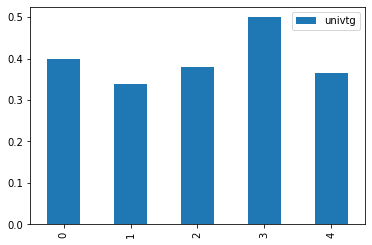

In [12]:
data[data['content_id'] == 1000053838][['start_position_scene', 'univtg']].plot.bar()